## Image Recognition

In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.constraints import max_norm
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 5120     # Training size
valid_size  = 1024     # Validation size
test_size   = 1050     # Test size
epochs      = 40       # Number of epochs

Load image data:

In [4]:
img_rows, img_cols, nb_channels = 32, 32, 1
input_dir = ".";


decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

In [5]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

Reduce the dimensionality of the image to get only the energy:

In [6]:
X_train_channel0 = X_train[:,:,:,0]
X_valid_channel0 = X_valid[:,:,:,0]
X_test_channel0 = X_test[:,:,:,0]
X_train_channel0 = np.reshape(X_train_channel0, X_train_channel0.shape + (1,))
X_valid_channel0 = np.reshape(X_valid_channel0, X_valid_channel0.shape + (1,))
X_test_channel0 = np.reshape(X_test_channel0, X_test_channel0.shape + (1,))

In [7]:
X_train_channel0.shape

(10240, 32, 32, 1)

In [9]:
### Define CNN Model ###

model = Sequential()
model.add(Conv2D(64, activation='relu', kernel_size=4, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(64, activation='relu', kernel_size=4, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(32, activation='relu', kernel_size=4, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=4, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_constraint=max_norm(2.), kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu',kernel_constraint=max_norm(2.), kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1088      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        32800     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.1, patience=5, min_lr=1.e-7) #val_loss #acc,loss,val_acc,val_loss,lr
history=model.fit(X_train_channel0, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid_channel0, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 10240 samples, validate on 2048 samples
Epoch 1/40
10240/10240 [==============================] - 93s 9ms/step - loss: 0.6779 - acc: 0.5779 - val_loss: 0.6561 - val_acc: 0.6206
Epoch 2/40
10240/10240 [==============================] - 94s 9ms/step - loss: 0.6651 - acc: 0.6025 - val_loss: 0.6506 - val_acc: 0.6226
Epoch 3/40
10240/10240 [==============================] - 94s 9ms/step - loss: 0.6540 - acc: 0.6196 - val_loss: 0.6459 - val_acc: 0.6416
Epoch 4/40
10240/10240 [==============================] - 94s 9ms/step - loss: 0.6374 - acc: 0.6439 - val_loss: 0.6008 - val_acc: 0.6816
Epoch 5/40
10240/10240 [==============================] - 94s 9ms/step - loss: 0.6262 - acc: 0.6600 - val_loss: 0.5954 - val_acc: 0.6934
Epoch 6/40
10240/10240 [==============================] - 94s 9ms/step - loss: 0.6214 - acc: 0.6641 - val_loss: 0.5946 - val_acc: 0.6909
Epoch 7/40
10240/10240 [==============================] - 96s 9ms/step - loss: 0.

['acc', 'loss', 'val_acc', 'val_loss', 'lr']


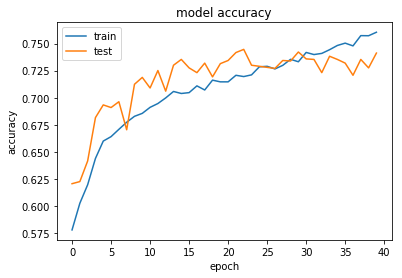

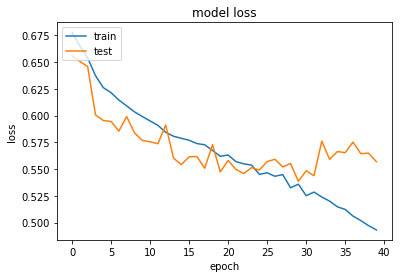

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2048/2048 [==============================] - 5s 2ms/step

Validation loss / accuracy: 0.5569 / 0.7412
('Validation ROC AUC:', 0.7977838516235352)


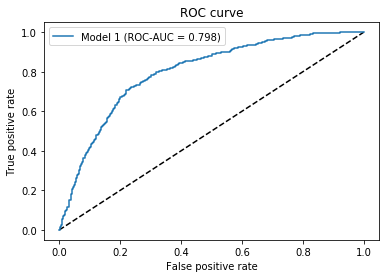

2100/2100 [==============================] - 5s 3ms/step

Test loss / accuracy: 0.5776 / 0.7257
('Test ROC AUC:', 0.7906462585034012)


In [11]:
# Evaluate on validation set
score = model.evaluate(X_valid_channel0, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid_channel0)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Evaluate on test set
score = model.evaluate(X_test_channel0, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test_channel0)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()